<a href="https://colab.research.google.com/github/AnanyaaKS/ML-Package/blob/main/MultilabelStratifiedKFold_5_folds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving sample_submission.csv to sample_submission.csv
Saving test_features.csv to test_features.csv
Saving train_drug.csv to train_drug.csv
Saving train_features.csv to train_features.csv
Saving train_targets_nonscored.csv to train_targets_nonscored.csv
Saving train_targets_scored.csv to train_targets_scored.csv


In [ ]:
!pip install scikit-multilearn
!pip install category_encoders


In [ ]:
!pip install iterative-stratification


In [ ]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold


In [ ]:
import os
import gc
import random
import math
import time

import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
from sklearn.metrics import log_loss

import category_encoders as ce

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import torch.nn.functional as F

import warnings
warnings.filterwarnings("ignore")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
def get_logger(filename='log'):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

logger = get_logger()


def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed=42)

In [ ]:
train_features = pd.read_csv('train_features.csv')
train_targets_scored = pd.read_csv('train_targets_scored.csv')
train_targets_nonscored = pd.read_csv('train_targets_nonscored.csv')
test_features = pd.read_csv('test_features.csv')
submission = pd.read_csv('sample_submission.csv')

In [ ]:
train = train_features.merge(train_targets_scored, on='sig_id')
target_cols = [c for c in train_targets_scored.columns if c not in ['sig_id']]
cols = target_cols + ['cp_type']
train[cols].groupby('cp_type').sum().sum(1)

cp_type
ctl_vehicle        0
trt_cp         16844
dtype: int64

In [ ]:
# constrcut train&test except 'cp_type'=='ctl_vehicle' data
print(train_features.shape, test_features.shape)
train = train[train['cp_type']!='ctl_vehicle'].reset_index(drop=True)
test = test_features[test_features['cp_type']!='ctl_vehicle'].reset_index(drop=True)
print(train.shape, test.shape)

(23814, 876) (3982, 876)
(21948, 1082) (3624, 876)


In [ ]:
folds = train.copy()
Fold = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds[target_cols])):
    folds.loc[val_index, 'fold'] = int(n)
folds['fold'] = folds['fold'].astype(int)
print(folds.shape)

(21948, 1083)


In [ ]:
class TrainDataset(Dataset):
    def __init__(self, df, num_features, cat_features, labels):
        self.cont_values = df[num_features].values
        self.cate_values = df[cat_features].values
        self.labels = labels

    def __len__(self):
        return len(self.cont_values)

    def __getitem__(self, idx):
        cont_x = torch.FloatTensor(self.cont_values[idx])
        cate_x = torch.LongTensor(self.cate_values[idx])
        label = torch.tensor(self.labels[idx]).float()

        return cont_x, cate_x, label


class TestDataset(Dataset):
    def __init__(self, df, num_features, cat_features):
        self.cont_values = df[num_features].values
        self.cate_values = df[cat_features].values

    def __len__(self):
        return len(self.cont_values)

    def __getitem__(self, idx):
        cont_x = torch.FloatTensor(self.cont_values[idx])
        cate_x = torch.LongTensor(self.cate_values[idx])

        return cont_x, cate_x

In [ ]:
cat_features = ['cp_time', 'cp_dose']
num_features = [c for c in train.columns if train.dtypes[c] != 'object']
num_features = [c for c in num_features if c not in cat_features]
num_features = [c for c in num_features if c not in target_cols]
target = train[target_cols].values

def cate2num(df):
    df['cp_time'] = df['cp_time'].map({24: 0, 48: 1, 72: 2})
    df['cp_dose'] = df['cp_dose'].map({'D1': 3, 'D2': 4})
    return df

train = cate2num(train)
test = cate2num(test)

In [ ]:
class CFG:
    max_grad_norm=1000
    gradient_accumulation_steps=1
    hidden_size=512
    dropout=0.5
    lr=1e-2
    weight_decay=1e-6
    batch_size=32
    epochs=20
    #total_cate_size=5
    #emb_size=4
    num_features=num_features
    cat_features=cat_features
    target_cols=target_cols

In [ ]:
class TabularNN(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.mlp = nn.Sequential(
                          nn.Linear(len(cfg.num_features), cfg.hidden_size),
                          nn.BatchNorm1d(cfg.hidden_size),
                          nn.Dropout(cfg.dropout),
                          nn.PReLU(),
                          nn.Linear(cfg.hidden_size, cfg.hidden_size),
                          nn.BatchNorm1d(cfg.hidden_size),
                          nn.Dropout(cfg.dropout),
                          nn.PReLU(),
                          nn.Linear(cfg.hidden_size, len(cfg.target_cols)),
                          )

    def forward(self, cont_x, cate_x):
        # no use of cate_x yet
        x = self.mlp(cont_x)
        return x

In [ ]:
def train_fn(train_loader, model, optimizer, epoch, scheduler, device):

    losses = AverageMeter()

    model.train()

    for step, (cont_x, cate_x, y) in enumerate(train_loader):

        cont_x, cate_x, y = cont_x.to(device), cate_x.to(device), y.to(device)
        batch_size = cont_x.size(0)

        pred = model(cont_x, cate_x)

        loss = nn.BCEWithLogitsLoss()(pred, y)
        losses.update(loss.item(), batch_size)

        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps

        loss.backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)

        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            scheduler.step()
            optimizer.step()
            optimizer.zero_grad()

    return losses.avg


def validate_fn(valid_loader, model, device):

    losses = AverageMeter()

    model.eval()
    val_preds = []

    for step, (cont_x, cate_x, y) in enumerate(valid_loader):

        cont_x, cate_x, y = cont_x.to(device), cate_x.to(device), y.to(device)
        batch_size = cont_x.size(0)

        with torch.no_grad():
            pred = model(cont_x, cate_x)

        loss = nn.BCEWithLogitsLoss()(pred, y)
        losses.update(loss.item(), batch_size)

        val_preds.append(pred.sigmoid().detach().cpu().numpy())

        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps

    val_preds = np.concatenate(val_preds)

    return losses.avg, val_preds


def inference_fn(test_loader, model, device):

    model.eval()
    preds = []

    for step, (cont_x, cate_x) in enumerate(test_loader):

        cont_x,  cate_x = cont_x.to(device), cate_x.to(device)

        with torch.no_grad():
            pred = model(cont_x, cate_x)

        preds.append(pred.sigmoid().detach().cpu().numpy())

    preds = np.concatenate(preds)

    return preds


class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def run_single_nn(cfg, train, test, folds, num_features, cat_features, target, device, fold_num=0, seed=42):

    # Set seed
    logger.info(f'Set seed {seed}')
    seed_everything(seed=seed)

    # loader
    trn_idx = folds[folds['fold'] != fold_num].index
    val_idx = folds[folds['fold'] == fold_num].index
    train_folds = train.loc[trn_idx].reset_index(drop=True)
    valid_folds = train.loc[val_idx].reset_index(drop=True)
    train_target = target[trn_idx]
    valid_target = target[val_idx]
    train_dataset = TrainDataset(train_folds, num_features, cat_features, train_target)
    valid_dataset = TrainDataset(valid_folds, num_features, cat_features, valid_target)
    train_loader = DataLoader(train_dataset, batch_size=cfg.batch_size, shuffle=True,
                              num_workers=4, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, batch_size=cfg.batch_size, shuffle=False,
                              num_workers=4, pin_memory=True, drop_last=False)

    # model
    model = TabularNN(cfg)
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e3,
                                              max_lr=1e-2, epochs=cfg.epochs, steps_per_epoch=len(train_loader))

    # log
    log_df = pd.DataFrame(columns=(['EPOCH']+['TRAIN_LOSS']+['VALID_LOSS']) )

    # train & validate
    best_loss = np.inf
    for epoch in range(cfg.epochs):
        train_loss = train_fn(train_loader, model, optimizer, epoch, scheduler, device)
        valid_loss, val_preds = validate_fn(valid_loader, model, device)
        log_row = {'EPOCH': epoch,
                   'TRAIN_LOSS': train_loss,
                   'VALID_LOSS': valid_loss,
                  }
        log_df = log_df.append(pd.DataFrame(log_row, index=[0]), sort=False)
        #logger.info(log_df.tail(1))
        if valid_loss < best_loss:
            logger.info(f'epoch{epoch} save best model... {valid_loss}')
            best_loss = valid_loss
            oof = np.zeros((len(train), len(cfg.target_cols)))
            oof[val_idx] = val_preds
            torch.save(model.state_dict(), f"fold{fold_num}_seed{seed}.pth")

    # predictions
    test_dataset = TestDataset(test, num_features, cat_features)
    test_loader = DataLoader(test_dataset, batch_size=cfg.batch_size, shuffle=False,
                             num_workers=4, pin_memory=True)
    model = TabularNN(cfg)
    model.load_state_dict(torch.load(f"fold{fold_num}_seed{seed}.pth"))
    model.to(device)
    predictions = inference_fn(test_loader, model, device)

    # del
    torch.cuda.empty_cache()

    return oof, predictions


def run_kfold_nn(cfg, train, test, folds, num_features, cat_features, target, device, n_fold=5, seed=42):

    oof = np.zeros((len(train), len(cfg.target_cols)))
    predictions = np.zeros((len(test), len(cfg.target_cols)))

    for _fold in range(n_fold):
        logger.info("Fold {}".format(_fold))
        _oof, _predictions = run_single_nn(cfg,
                                           train,
                                           test,
                                           folds,
                                           num_features,
                                           cat_features,
                                           target,
                                           device,
                                           fold_num=_fold,
                                           seed=seed)
        oof += _oof
        predictions += _predictions / n_fold

    score = 0
    for i in range(target.shape[1]):
        _score = log_loss(target[:,i], oof[:,i])
        score += _score / target.shape[1]
    logger.info(f"CV score: {score}")

    return oof, predictions

In [ ]:
# Seed Averaging for solid result
oof = np.zeros((len(train), len(CFG.target_cols)))
predictions = np.zeros((len(test), len(CFG.target_cols)))

SEED = [0, 1, 2]
for seed in SEED:
    _oof, _predictions = run_kfold_nn(CFG,
                                      train, test, folds,
                                      num_features, cat_features, target,
                                      device,
                                      n_fold=5, seed=seed)
    oof += _oof / len(SEED)
    predictions += _predictions / len(SEED)

score = 0
for i in range(target.shape[1]):
    _score = log_loss(target[:,i], oof[:,i])
    score += _score / target.shape[1]
logger.info(f"Seed Averaged CV score: {score}")

Fold 0
INFO:__main__:Fold 0
Set seed 0
INFO:__main__:Set seed 0
epoch0 save best model... 0.02071887279790667
INFO:__main__:epoch0 save best model... 0.02071887279790667
epoch1 save best model... 0.01981006714776328
INFO:__main__:epoch1 save best model... 0.01981006714776328
epoch2 save best model... 0.017941880097574553
INFO:__main__:epoch2 save best model... 0.017941880097574553
epoch3 save best model... 0.017566132226403047
INFO:__main__:epoch3 save best model... 0.017566132226403047
epoch4 save best model... 0.017535330944934303
INFO:__main__:epoch4 save best model... 0.017535330944934303
epoch5 save best model... 0.017382889050472704
INFO:__main__:epoch5 save best model... 0.017382889050472704
epoch6 save best model... 0.017264557708742134
INFO:__main__:epoch6 save best model... 0.017264557708742134
epoch7 save best model... 0.017198576618639376
INFO:__main__:epoch7 save best model... 0.017198576618639376
epoch10 save best model... 0.017073312051305738
INFO:__main__:epoch10 save b

In [ ]:
train[target_cols] = oof
train[['sig_id']+target_cols].to_csv('oof.csv', index=False)

test[target_cols] = predictions
test[['sig_id']+target_cols].to_csv('pred.csv', index=False)

In [ ]:
# Final result with 'cp_type'=='ctl_vehicle' data
result = train_targets_scored.drop(columns=target_cols)\
            .merge(train[['sig_id']+target_cols], on='sig_id', how='left').fillna(0)
y_true = train_targets_scored[target_cols].values
y_pred = result[target_cols].values
score = 0
for i in range(y_true.shape[1]):
    _score = log_loss(y_true[:,i], y_pred[:,i])
    score += _score / y_true.shape[1]
logger.info(f"Final result: {score}")

Final result: 0.014822212293742126
INFO:__main__:Final result: 0.014822212293742126


In [ ]:
sub = submission.drop(columns=target_cols).merge(test[['sig_id']+target_cols], on='sig_id', how='left').fillna(0)
sub.to_csv('submission.csv', index=False)
sub.head()

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_0004d9e33,0.000792,0.001464,0.001786,0.013734,0.032672,0.004647,0.001377,0.007129,0.000098,...,0.000594,0.000994,0.003284,0.000304,0.000367,0.000627,0.000139,0.001850,0.003245,0.001232
1,id_001897cda,0.000280,0.000711,0.001633,0.001463,0.001134,0.001385,0.005871,0.007396,0.008775,...,0.000549,0.000462,0.004384,0.000102,0.008968,0.000379,0.005228,0.000507,0.000984,0.002710
2,id_002429b5b,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,id_00276f245,0.001155,0.000536,0.002298,0.017399,0.016639,0.004673,0.002954,0.002930,0.000100,...,0.000646,0.000439,0.004440,0.026943,0.007626,0.000538,0.001460,0.003062,0.000141,0.003636
4,id_0027f1083,0.002394,0.002979,0.002061,0.016691,0.021168,0.004821,0.009537,0.001196,0.000317,...,0.001028,0.000362,0.008019,0.004452,0.000890,0.000866,0.000595,0.002127,0.000074,0.001551


PCA - CV -LR

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression

In [ ]:
s_submission = pd.read_csv('sample_submission.csv')

In [ ]:
def average_log_loss(y_true, y_pred):
    print(y_true.shape, y_pred.shape)
    num_samples, num_outputs = y_true.shape
    loss = 0.00
    for i in range(num_outputs):
        loss += log_loss(y_true[:, i], y_pred[:, i], labels=[0, 1])
    loss /= num_outputs
    return loss

In [ ]:
def preprocess(df):
    df = df.drop(columns=['sig_id'])
    df.cp_dose = df.cp_dose.map({'D1': -1, 'D2': 1})
    df.cp_time = df.cp_time.map({24: -1, 48: 0, 72: 1})
    df.cp_type = df.cp_type.map({'trt_cp': -1, 'ctl_vehicle': 1})
    return df

In [ ]:
train_features = preprocess(train_features)
train_targets_scored = train_targets_scored.drop(columns=['sig_id'])
test_features = preprocess(test_features)

targets_np = train_targets_scored.to_numpy()

In [ ]:
g_cols = [col for col in train_features.columns if col.startswith('g-')]
c_cols = [col for col in train_features.columns if col.startswith('c-')]
cp_cols = [col for col in train_features.columns if col.startswith('cp_')]

def scaler_and_PCA(pca_num_components, train, test):
    data = np.concatenate((train, test), axis=0)
    n = train.shape[0]

    # variance threshold
    selector = VarianceThreshold(threshold=0.8)
    data = selector.fit_transform(data)

    # scale
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)

    # PCA
    pca = PCA(pca_num_components)
    pca_data = pca.fit_transform(scaled_data)

    train_trans = pca_data[:n, :]
    test_trans = pca_data[n:, :]

    return train_trans, test_trans


# For columns "g-"
train_X_g = train_features[g_cols].to_numpy()
test_X_g = test_features[g_cols].to_numpy()
train_X_g, test_X_g = scaler_and_PCA(80, train_X_g, test_X_g)

# For columns "c-"
train_X_c = train_features[c_cols].to_numpy()
test_X_c = test_features[c_cols].to_numpy()
train_X_c, test_X_c = scaler_and_PCA(20, train_X_c, test_X_c)

features_np = np.concatenate((train_features[cp_cols].to_numpy(), train_X_g, train_X_c), axis=1)
test_np = np.concatenate((test_features[cp_cols].to_numpy(), test_X_g, test_X_c), axis=1)
print('Shape after scaler and PCA', features_np.shape)

Shape after scaler and PCA (23814, 103)


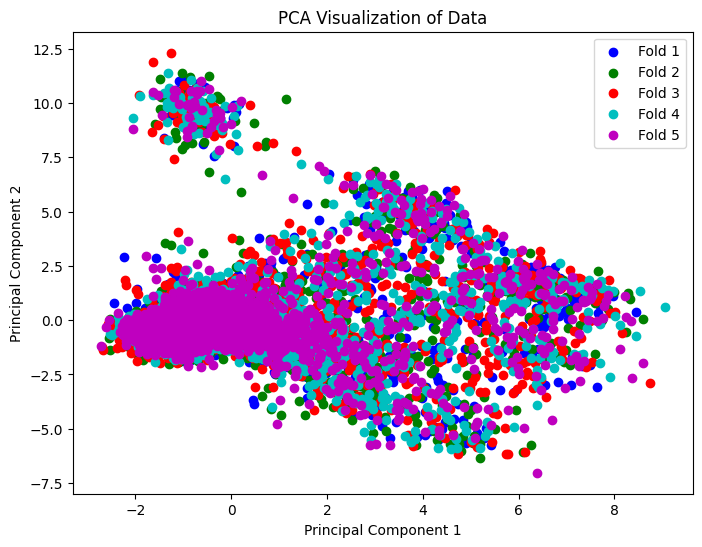

FIT


100%|██████████| 206/206 [01:40<00:00,  2.05it/s]


PREDICT


100%|██████████| 206/206 [00:00<00:00, 315.09it/s]


VALIDATE
Log_loss 1 0.016449915457499104
FIT


100%|██████████| 206/206 [01:30<00:00,  2.28it/s]


PREDICT


100%|██████████| 206/206 [00:00<00:00, 725.42it/s]


VALIDATE
Log_loss 2 0.016667178604132426
FIT


100%|██████████| 206/206 [01:20<00:00,  2.55it/s]


PREDICT


100%|██████████| 206/206 [00:00<00:00, 363.19it/s]


VALIDATE
Log_loss 3 0.01653556808208745
FIT


100%|██████████| 206/206 [01:22<00:00,  2.50it/s]


PREDICT


100%|██████████| 206/206 [00:00<00:00, 813.80it/s]


VALIDATE
Log_loss 4 0.016689029118221996
FIT


100%|██████████| 206/206 [01:11<00:00,  2.87it/s]


PREDICT


100%|██████████| 206/206 [00:00<00:00, 828.16it/s]


VALIDATE
Log_loss 5 0.016767927191006192
Best loss is: 0.016449915457499104


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from tqdm import tqdm

# Your existing code here

best_model = None
best_loss = 999999999999999999
kf = KFold(n_splits=5)
j = 1

# Perform PCA
X_scaled = StandardScaler().fit_transform(features_np)  # Standardize the features
pca = PCA(n_components=2)  # You can change the number of components as needed
principal_components = pca.fit_transform(X_scaled)

# Visualize the principal components
plt.figure(figsize=(8, 6))
colors = ['b', 'g', 'r', 'c', 'm']
for i, (train_indices, val_indices) in enumerate(kf.split(features_np)):
    plt.scatter(
        principal_components[val_indices, 0],
        principal_components[val_indices, 1],
        label=f'Fold {i + 1}',
        color=colors[i]
    )

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Visualization of Data')
plt.legend()
plt.show()

for train_indices, val_indices in kf.split(features_np):
    X_train, Y_train = features_np[train_indices, :], targets_np[train_indices, :]
    X_val, Y_val = features_np[val_indices, :], targets_np[val_indices, :]

    all_categories = list(train_targets_scored.columns)
    model_dict = {}
    print('FIT')
    for i in tqdm(range(206)):
        if Y_train[:, i].max() == 0:
            # use last model
            model_dict[all_categories[i]] = logistic_model
        else:
            logistic_model = LogisticRegression(C=0.1, max_iter=1000, class_weight={0: 0.4, 1: 0.6})
            logistic_model.fit(X_train, Y_train[:, i])
            # saving model
            model_dict[all_categories[i]] = logistic_model
    print('PREDICT')
    Y_pred = np.zeros(Y_val.shape)
    i = 0
    for category in tqdm(all_categories):
        Y_pred[:, i] = np.copy(model_dict[category].predict_proba(X_val)[:, 1])
        i += 1
    print('VALIDATE')
    cur_loss = average_log_loss(Y_val, Y_pred)
    print('Log_loss', j, cur_loss)
    if cur_loss < best_loss:
        best_model = model_dict
        best_loss = cur_loss
    j += 1

print('Best loss is:', best_loss)


FIT


100%|██████████| 206/206 [01:18<00:00,  2.63it/s]


PREDICT


100%|██████████| 206/206 [00:00<00:00, 723.85it/s]


VALIDATE
Log_loss 1 0.016449915457499104
FIT


100%|██████████| 206/206 [01:20<00:00,  2.55it/s]


PREDICT


100%|██████████| 206/206 [00:00<00:00, 836.70it/s]


VALIDATE
Log_loss 2 0.016667178604132426
FIT


100%|██████████| 206/206 [01:19<00:00,  2.59it/s]


PREDICT


100%|██████████| 206/206 [00:00<00:00, 805.41it/s]


VALIDATE
Log_loss 3 0.01653556808208745
FIT


100%|██████████| 206/206 [01:32<00:00,  2.22it/s]


PREDICT


100%|██████████| 206/206 [00:00<00:00, 791.27it/s]


VALIDATE
Log_loss 4 0.016689029118221996
FIT


100%|██████████| 206/206 [01:18<00:00,  2.62it/s]


PREDICT


100%|██████████| 206/206 [00:00<00:00, 867.60it/s]


VALIDATE
Log_loss 5 0.016767927191006192


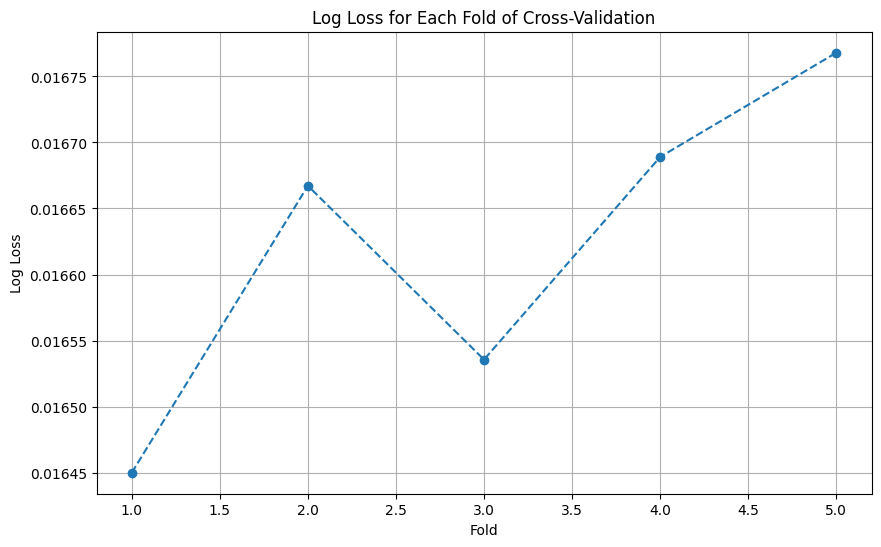

Best loss is: 0.016449915457499104


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from tqdm import tqdm

# Define average log loss function
def average_log_loss(y_true, y_pred):
    num_samples, num_outputs = y_true.shape
    loss = 0.00
    for i in range(num_outputs):
        loss += log_loss(y_true[:, i], y_pred[:, i], labels=[0, 1])
    loss /= num_outputs
    return loss

# Preprocess data
def preprocess(df):
    df = df.drop(columns=['sig_id'])
    df.cp_dose = df.cp_dose.map({'D1': -1, 'D2': 1})
    df.cp_time = df.cp_time.map({24: -1, 48: 0, 72: 1})
    df.cp_type = df.cp_type.map({'trt_cp': -1, 'ctl_vehicle': 1})
    return df

# Feature selection, scaling, and PCA
def scaler_and_PCA(pca_num_components, train, test):
    data = np.concatenate((train, test), axis=0)
    n = train.shape[0]

    # Variance threshold
    selector = VarianceThreshold(threshold=0.8)
    data = selector.fit_transform(data)

    # Scale
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)

    # PCA
    pca = PCA(n_components=pca_num_components)
    pca_data = pca.fit_transform(scaled_data)

    train_trans = pca_data[:n, :]
    test_trans = pca_data[n:, :]

    return train_trans, test_trans
s
# Initialize lists to store log loss values for each fold
log_loss_values = []

# Initialize variables for the best model and best loss
best_model = None
best_loss = 999999999999999999

kf = KFold(n_splits=5)
j = 1
for train_indices, val_indices in kf.split(features_np):
    X_train, Y_train = features_np[train_indices, :], targets_np[train_indices, :]
    X_val, Y_val = features_np[val_indices, :], targets_np[val_indices, :]

    all_categories = list(train_targets_scored.columns)
    model_dict = {}
    print('FIT')
    for i in tqdm(range(206)):
        if Y_train[:, i].max() == 0:
            # Use the last model
            model_dict[all_categories[i]] = logistic_model
        else:
            logistic_model = LogisticRegression(C=0.1, max_iter=1000, class_weight={0: 0.4, 1: 0.6})
            logistic_model.fit(X_train, Y_train[:, i])
            # Save the model
            model_dict[all_categories[i]] = logistic_model
    print('PREDICT')
    Y_pred = np.zeros(Y_val.shape)
    i = 0
    for category in tqdm(all_categories):
        Y_pred[:, i] = np.copy(model_dict[category].predict_proba(X_val)[:, 1])
        i += 1
    print('VALIDATE')
    cur_loss = average_log_loss(Y_val, Y_pred)
    print('Log_loss', j, cur_loss)
    log_loss_values.append(cur_loss)
    if cur_loss < best_loss:
        best_model = model_dict
        best_loss = cur_loss
    j += 1

# Plot log loss for each fold
plt.figure(figsize=(10, 6))
plt.plot(range(1, j), log_loss_values, marker='o', linestyle='--')
plt.title('Log Loss for Each Fold of Cross-Validation')
plt.xlabel('Fold')
plt.ylabel('Log Loss')
plt.grid()
plt.show()

print('Best loss is:', best_loss)




In [ ]:
best_model = None
best_loss = 999999999999999999
kf = KFold(n_splits=5)
j = 1
for train_indices, val_indices in kf.split(features_np):
    X_train, Y_train = features_np[train_indices, :], targets_np[train_indices, :]
    X_val, Y_val = features_np[val_indices, :], targets_np[val_indices, :]

    all_categories = list(train_targets_scored.columns)
    model_dict = {}
    print('FIT')
    for i in tqdm(range(206)):
        if Y_train[:, i].max() == 0:
            # use last model
            model_dict[all_categories[i]] = logistic_model
        else:
            logistic_model = LogisticRegression(C=0.1, max_iter=1000, class_weight={0: 0.4, 1: 0.6})
            logistic_model.fit(X_train, Y_train[:, i])
            # saving model
            model_dict[all_categories[i]] = logistic_model
    print('PREDICT')
    Y_pred = np.zeros(Y_val.shape)
    i = 0
    for category in tqdm(all_categories):
        Y_pred[:, i] = np.copy(model_dict[category].predict_proba(X_val)[:, 1])
        i += 1
    print('VALIDATE')
    cur_loss = average_log_loss(Y_val, Y_pred)
    print('Log_loss', j, cur_loss)
    if cur_loss < best_loss:
        best_model = model_dict
        best_loss = cur_loss
    j += 1

print('Best loss is:', best_loss)

FIT


100%|██████████| 206/206 [01:23<00:00,  2.46it/s]


PREDICT


100%|██████████| 206/206 [00:00<00:00, 1091.01it/s]


VALIDATE
(4763, 206) (4763, 206)
Log_loss 1 0.016449915457499104
FIT


100%|██████████| 206/206 [01:01<00:00,  3.35it/s]


PREDICT


100%|██████████| 206/206 [00:00<00:00, 783.30it/s]


VALIDATE
(4763, 206) (4763, 206)
Log_loss 2 0.016667178604132426
FIT


100%|██████████| 206/206 [01:08<00:00,  3.02it/s]


PREDICT


100%|██████████| 206/206 [00:00<00:00, 1098.56it/s]


VALIDATE
(4763, 206) (4763, 206)
Log_loss 3 0.01653556808208745
FIT


100%|██████████| 206/206 [00:56<00:00,  3.63it/s]


PREDICT


100%|██████████| 206/206 [00:00<00:00, 813.58it/s]


VALIDATE
(4763, 206) (4763, 206)
Log_loss 4 0.016689029118221996
FIT


100%|██████████| 206/206 [00:50<00:00,  4.06it/s]


PREDICT


100%|██████████| 206/206 [00:00<00:00, 938.41it/s]


VALIDATE
(4762, 206) (4762, 206)
Log_loss 5 0.016767927191006192
Best loss is: 0.016449915457499104


In [ ]:
Y_res = s_submission.drop(columns=['sig_id']).to_numpy()
i = 0
all_categories = list(train_targets_scored.columns)
print('PREDICT RESULT')
for category in tqdm(all_categories):
    Y_res[:, i] = np.copy(best_model[category].predict_proba(test_np)[:, 1])
    i += 1
# POSTPROCESS
for i in range(test_np.shape[0]):
    if test_np[i][0] == 1:
        Y_res[i, :] = np.zeros(Y_res.shape[1])
s_res = pd.DataFrame(Y_res, columns=all_categories)
s_res = pd.concat([s_submission['sig_id'], s_res], axis=1)
s_res.to_csv('submission.csv', index=False)

PREDICT RESULT


100%|██████████| 206/206 [00:00<00:00, 813.04it/s]
